In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
image_dir = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    img_dir = dirname
#     for filename in filenames:
#         img_dir = os.path.join(dirname, filename)

print(img_dir)

# Any results you write to the current directory are saved as output.

/kaggle/input/pokemon-images-dataset/pokemon/pokemon


You have to create a subdirectory in the image folder - otherwise when loading with datasets.ImageFolder will
return an error that 0 files are present in the directory even if the images are presents in the folder.

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

train_on_gpu = True if torch.cuda.is_available() else False
train_on_gpu

True

/kaggle/input/pokemon-images-dataset/pokemon/133.png


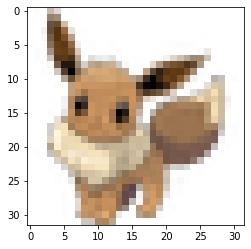

In [32]:
a = ''
img_dir = '/kaggle/input/pokemon-images-dataset/pokemon/'
for file in os.listdir(img_dir):
    a = file
    break
dir = img_dir + a
print(dir)
a = Image.open(dir)
a.thumbnail((32, 32), Image.ANTIALIAS)
plt.imshow(a)
plt.show()

In [35]:
transform = transforms.Compose([
                        transforms.Resize(size=(32, 32)),
                        transforms.ToTensor()
                            ])

images = datasets.ImageFolder(root=img_dir, transform=transform)

In [37]:
train = torch.utils.data.DataLoader(images, batch_size=64, num_workers=0, shuffle=True)

In [38]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=False):
    layers = []
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv)
    if batch_norm:
        batch_norm_layer = nn.BatchNorm2d(out_channels)
        layers.append(batch_norm_layer)
        
    return nn.Sequential(*layers)

In [39]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()
        ## 32x32x3
        self.conv1 = conv(3, conv_dim) ## 16x16x32
        self.conv2 = conv(conv_dim, conv_dim*2, batch_norm=True) ## 8x8x64
        self.conv3 = conv(conv_dim*2, conv_dim*4) ## 4x4x128
#         self.conv4 = conv(conv_dim*4, conv_dim*8, kernel_size=3, stride=1, batch_norm=True) ## 8x8x256
#         self.conv5 = conv(conv_dim*8, conv_dim*16) ## 4x4x512
        
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
#         x = F.leaky_relu(self.conv4(x), 0.2)
#         x = F.leaky_relu(self.conv5(x), 0.2)
        
        x = x.view(-1, 4*4*128)
        x = self.fc(x)
        
        return x
    

In [40]:
def deconv(in_channel, out_channel, kernel_size=4, stride=2, padding=1, batch_norm=False):
    layers = []
    decon = nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride, padding, bias=False)
    layers.append(decon)
    if batch_norm:
        batch_layer = nn.BatchNorm2d(out_channel)
        layers.append(batch_layer)
        
    return nn.Sequential(*layers)

In [41]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()
        
        self.fc = nn.Linear(z_size, 4*4*8*conv_dim)
        ## 4x4x256
        self.deconv1 = deconv(8*conv_dim, conv_dim*4, batch_norm=True) ## 8x8x128
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, batch_norm=True) ## 16x16x64
        self.deconv3 = deconv(conv_dim*2, conv_dim, batch_norm=True) ## 32x32x32
        self.deconv4 = deconv(conv_dim, 3, kernel_size=3, stride=1) ## 32x32x3
#         self.deconv5 = deconv(conv_dim*2, 3, kernel_size=3, stride=1) ## 64x64x3
        
    def forward(self, x):
        x = self.fc(x)
        
        x = x.view(-1, 256, 4, 4)
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.tanh(self.deconv4(x))
#         x = F.tanh(self.deconv5(x))
        
        return x
        

In [42]:
z_size = 100
D = Discriminator()
G = Generator(z_size)

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [43]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [44]:
# lr_g = 0.0004
# lr_d = 0.00004
lr = 0.0002
beta1 = 0.5
beta2 = 0.9

d_optim = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optim = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [45]:
def scale(x):
    x = x*2 -1
    
    return x

In [46]:
import pickle as pkl 

n_epochs = 300
z_size = 100
samples = []
losses = []
print_every = 300
sample_size=8
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

for epoch in range(n_epochs):
    for batch_index, (real_images,_) in enumerate(train):

        batch_size = real_images.size(0)
        real_img = scale(real_images)

        ## DISCRIMINATOR LOSS ##
        d_optim.zero_grad()
        if train_on_gpu:
            real_img = real_img.cuda()

        real_pred = D(real_img)
        r_loss = real_loss(real_pred, smooth=True)

        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_img = G(z)
        fake_pred = D(fake_img)
        f_loss = fake_loss(fake_pred)

        d_loss = r_loss + f_loss
        d_loss.backward()
        d_optim.step()

        ## GENERATOR LOSS ##
        g_optim.zero_grad()

        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_img = G(z)
        ## Taking loss with flipped lables or real loss function to trick the D
        fake_pred = D(fake_img)
        f_loss_g = real_loss(fake_pred)

        g_loss = f_loss_g
        g_loss.backward()
        g_optim.step()

        if batch_index % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, n_epochs, d_loss.item(), g_loss.item()))
    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode
    
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
        

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  300] | d_loss: 1.3778 | g_loss: 0.8036
Epoch [    2/  300] | d_loss: 1.1241 | g_loss: 1.0946
Epoch [    3/  300] | d_loss: 1.0066 | g_loss: 1.4064
Epoch [    4/  300] | d_loss: 0.8691 | g_loss: 1.7779
Epoch [    5/  300] | d_loss: 0.8965 | g_loss: 1.9034
Epoch [    6/  300] | d_loss: 1.2240 | g_loss: 1.3822
Epoch [    7/  300] | d_loss: 1.0860 | g_loss: 1.4711
Epoch [    8/  300] | d_loss: 1.3129 | g_loss: 1.1638
Epoch [    9/  300] | d_loss: 1.2868 | g_loss: 1.2145
Epoch [   10/  300] | d_loss: 1.1967 | g_loss: 1.3140
Epoch [   11/  300] | d_loss: 1.1892 | g_loss: 1.2628
Epoch [   12/  300] | d_loss: 1.2511 | g_loss: 1.0807
Epoch [   13/  300] | d_loss: 1.2068 | g_loss: 1.2695
Epoch [   14/  300] | d_loss: 1.0763 | g_loss: 1.3904
Epoch [   15/  300] | d_loss: 1.1437 | g_loss: 1.5050
Epoch [   16/  300] | d_loss: 1.4328 | g_loss: 1.4370
Epoch [   17/  300] | d_loss: 1.1555 | g_loss: 1.3278
Epoch [   18/  300] | d_loss: 0.9351 | g_loss: 1.7451
Epoch [   19/  300] | d_loss

Epoch [  153/  300] | d_loss: 0.9578 | g_loss: 1.3127
Epoch [  154/  300] | d_loss: 1.3629 | g_loss: 2.1801
Epoch [  155/  300] | d_loss: 1.1444 | g_loss: 1.6138
Epoch [  156/  300] | d_loss: 1.1426 | g_loss: 1.1470
Epoch [  157/  300] | d_loss: 1.1921 | g_loss: 1.0966
Epoch [  158/  300] | d_loss: 1.3001 | g_loss: 0.6744
Epoch [  159/  300] | d_loss: 1.0368 | g_loss: 1.5462
Epoch [  160/  300] | d_loss: 0.9850 | g_loss: 1.4337
Epoch [  161/  300] | d_loss: 1.1869 | g_loss: 0.9509
Epoch [  162/  300] | d_loss: 1.0011 | g_loss: 1.4933
Epoch [  163/  300] | d_loss: 1.1086 | g_loss: 1.4400
Epoch [  164/  300] | d_loss: 0.9876 | g_loss: 1.3402
Epoch [  165/  300] | d_loss: 1.1981 | g_loss: 1.4224
Epoch [  166/  300] | d_loss: 1.4484 | g_loss: 1.7228
Epoch [  167/  300] | d_loss: 0.9263 | g_loss: 1.4207
Epoch [  168/  300] | d_loss: 1.0771 | g_loss: 1.6002
Epoch [  169/  300] | d_loss: 1.1312 | g_loss: 1.5541
Epoch [  170/  300] | d_loss: 1.0879 | g_loss: 1.3154
Epoch [  171/  300] | d_loss

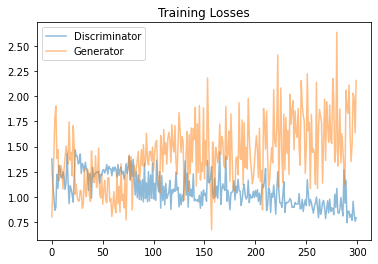

In [47]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [69]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
#         print(img[0][0])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

[0 0 0]
[1 2 2]
[1 2 2]
[0 1 0]
[1 2 1]
[0 0 1]
[0 1 1]
[0 0 0]


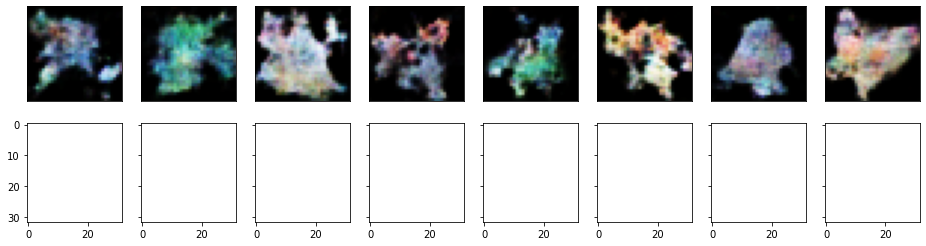

In [70]:
_ = view_samples(-1, samples)

In [ ]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
#         ax.imshow(img.reshape((64,64)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


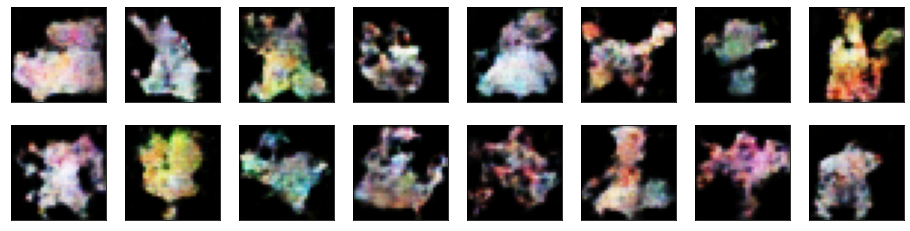

In [56]:
# randomly generated, new latent vectors
sample_size=16
z_size = 100
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float().cuda()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])